# Predict geothermal heat flux: KNN regression

References:
* http://rasbt.github.io/mlxtend/user_guide/feature_selection/SequentialFeatureSelector/
* https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
* https://github.com/amirkdv/ghf-greenland-gbrt

Ensure R17_global_test.csv and R17_global_train.csv is in the same directory as this notebook.

Install mlxtend to use SequentialFeatureSelector (pip install mlxtend).

In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsRegressor, LocalOutlierFactor
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.pipeline import Pipeline
from timeit import default_timer as timer
import math
from matplotlib import pyplot as plt
from sklearn.model_selection import GroupKFold
from sklearn.feature_selection import RFECV
from sklearn.model_selection import ParameterGrid
from multiprocessing import Pool
from tqdm.notebook import tqdm

In [2]:
def find_continent(df):
    cont = []
    for r in df.itertuples():
        if (r.lat > 0)  & (r.lon < -25): # NA
            cont.append(0)
        elif (r.lat > 30)  & (75 > r.lon) & (r.lon > -25): #EU
            cont.append(1)
        else:
            cont.append(2)
    return cont

Load the data.

In [3]:
X_labels = ["thickness_upper_crust",
            "thickness_middle_crust",
            "upper_mantle_density_anomaly",
            "d_2_ridge",
            "d_2_trench",
            "d_2_trans_ridge",
            "d_2_volcano",
            "d_2_hotspot",
            "thickness_crust",
            "d_2_young_rift",
#             "lon",
#             "lat".
#             "GHF",
            "upper_mantle_vel_structure",
            "age",
            "magnetic_anomaly",
            "depth_to_moho",
            "lithos_asthenos_bdry",
            "bougeur_gravity_anomaly",
            "topography"
]

y_lable = 'GHF'

# Load data
data_train = pd.read_csv('R17_global_train.csv')
data_train['continent'] = find_continent(data_train)
train = data_train
X_train = data_train[X_labels]
y_train = data_train[y_lable]

data_test = pd.read_csv('R17_global_test.csv')
data_test['continent'] = find_continent(data_test)
test = data_test
X_test = data_test[X_labels]
y_test = data_test[y_lable]
# Scale X
scaler = preprocessing.MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print('X_train shape:', X_train.shape)
print('y_train shape:', y_train.shape)
print('X_test shape:', X_test.shape)
print('y_test shape:', y_test.shape)

X_train shape: (3227, 17)
y_train shape: (3227,)
X_test shape: (807, 17)
y_test shape: (807,)


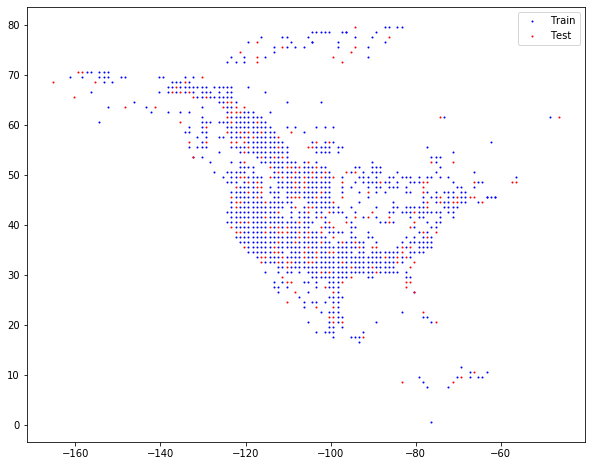

In [4]:
na_train = train[train['continent'] == 0]
na_test = test[test['continent'] == 0]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(na_train['lon'], na_train['lat'], s=1, c='b', label='Train')
ax.scatter(na_test['lon'], na_test['lat'], s=1, c='r', label='Test')
ax.legend()
plt.show()

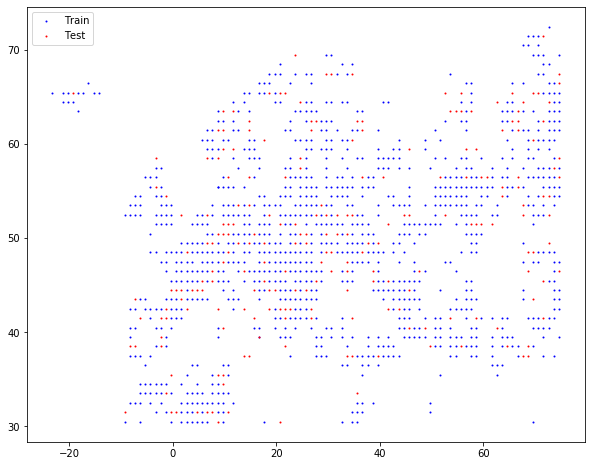

In [5]:
eu_train = train[train['continent'] == 1]
eu_test = test[test['continent'] == 1]

fig, ax = plt.subplots(figsize=(10, 8))
ax.scatter(eu_train['lon'], eu_train['lat'], s=1, c='b', label='Train')
ax.scatter(eu_test['lon'], eu_test['lat'], s=1, c='r', label='Test')
ax.legend()
plt.show()

In [6]:
eu_na_train = train[train['continent'] <= 1]
eu_na_test = test[test['continent'] <= 1]

X_eu_na_train = eu_na_train[X_labels]
y_eu_na_train = eu_na_train[y_lable]

X_eu_na_test = eu_na_test[X_labels]
y_eu_na_test = eu_na_test[y_lable]

Use sequential feature selection to decide what features to use. Grid search to determine best hyperparameter values.

In [8]:
gkf = GroupKFold(n_splits=2)
param_grid = {'n_neighbors': range(1, 50),
   'weights': ['distance', 'uniform'],
   'metric': ['euclidean', 'manhattan', 'chebyshev']}

poss_params = ParameterGrid(param_grid)

def find_sfs(params):
    knn = KNeighborsRegressor(n_neighbors=params['n_neighbors'], metric=params['metric'], weights=params['weights'])

    sfs = SFS(estimator=knn, 
               k_features='best',
               forward=False, 
               floating=True,
#                verbose=2,
               cv=gkf)

    sfs.fit(X_eu_na_train, y_eu_na_train, groups=list(eu_na_train['continent']))
    
    return sfs

# pool = Pool()
# sfss = pool.map(find_sfs, poss_params)
# pool.close()
# pool.join()

best_score = None
best_sfs = None

for params in tqdm(poss_params):
    sfs = find_sfs(params)
    
    if best_score is None or sfs.k_score_ > best_score:
        best_score = sfs.k_score_
        best_sfs = sfs

# best_sfs = sfss[sfss.index(max(sfss, key=lambda x: x.k_score_))]

In [9]:
# print(best_score)
print(best_sfs)
print(best_sfs.k_feature_names_)
print(best_sfs.k_score_)

SequentialFeatureSelector(clone_estimator=True, cv=GroupKFold(n_splits=2),
                          estimator=KNeighborsRegressor(algorithm='auto',
                                                        leaf_size=30,
                                                        metric='manhattan',
                                                        metric_params=None,
                                                        n_jobs=None,
                                                        n_neighbors=46, p=2,
                                                        weights='uniform'),
                          floating=True, forward=False, k_features='best',
                          n_jobs=1, pre_dispatch='2*n_jobs', scoring=None,
                          verbose=0)
('thickness_upper_crust', 'thickness_middle_crust', 'upper_mantle_density_anomaly', 'd_2_volcano', 'd_2_hotspot', 'thickness_crust', 'magnetic_anomaly')
0.34667689719978523


Fit a KNN model using the best hyperparameter values.

In [14]:
best_features = best_sfs.k_feature_names_
X_eu_na_train[list(best_features)]

,thickness_middle_crust,d_2_volcano,thickness_crust,upper_mantle_vel_structure
0,15.0,887.95,41.000000,1.0
2,13.5,530.13,43.490002,3.0
3,10.0,2366.71,39.509998,4.0
4,16.0,1487.38,42.299999,2.0
5,17.0,2036.97,46.459999,1.0
...,...,...,...,...
3221,16.0,1153.54,39.009998,2.0
3222,11.0,1342.86,34.630001,4.0
3223,8.0,1204.37,40.889999,4.0
3225,16.0,1404.25,40.130001,2.0


In [10]:
# Create subsets of train/test data using best features from SFS
knn = best_sfs.estimator
best_features = best_sfs.k_feature_names_
X_train_selected = X_eu_na_train[list(best_features)]
X_test_selected = X_eu_na_test[list(best_features)]

print(knn)
knn.fit(X_train_selected, y_eu_na_train)
print('R^2:', knn.score(X_test_selected, y_eu_na_test))
pred = knn.predict(X_test_selected)
rmse = (1 / np.average(y_eu_na_test)) * math.sqrt(np.average((y_eu_na_test - pred)**2))
print ('RMSE:', rmse)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='manhattan',
                    metric_params=None, n_jobs=None, n_neighbors=46, p=2,
                    weights='uniform')
R^2: 0.4669797417024025
RMSE: 0.21390988996624427
